## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import plotly.express as px

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Data

In [3]:
df = pd.read_csv('../data/processed/DataScientist_cleaned.csv')

## Preprocess Text Data


In [4]:
# Function to preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_job_description'] = df['Job Description'].apply(preprocess_text)

## Vectorize Text Data

In [5]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_job_description'])

## Apply Clustering Algorithm


In [33]:
# Apply KMeans clustering
num_clusters = 3  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign clusters to job descriptions
df['cluster'] = kmeans.labels_


C:\Users\krist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Analyze and Visualize Clusters


In [34]:
import plotly.graph_objects as go 

# Visualize clusters using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

# Create a DataFrame with the PCA results and cluster labels
pca_df = pd.DataFrame(principal_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = df['cluster'].astype(str)  # Convert to string for better color handling

# Get the coordinates of the centroids in the PCA space
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Create an interactive Plotly scatter plot with centroids
fig = px.scatter(
    pca_df, 
    x='PCA1', 
    y='PCA2', 
    color='cluster', 
    title='Job Description Clusters (PCA)',
    labels={'PCA1': 'PCA Component 1', 'PCA2': 'PCA Component 2'},
    color_discrete_sequence=px.colors.qualitative.Safe  # Using a discrete color scale
)

# Add centroids to the plot
fig.add_trace(go.Scatter(
    x=centroids_pca[:, 0],
    y=centroids_pca[:, 1],
    mode='markers',
    marker=dict(color='black', size=12, symbol='x'),
    name='Centroids'
))

# Update layout for better visualization
fig.update_layout(
    title='Job Description Clusters (PCA)',
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Cluster'
)

fig.show()

# Print cluster centers (top terms per cluster)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i} top terms:")
    for ind in order_centroids[i, :10]:  # Print top 10 terms per cluster
        print(f' {terms[ind]}')
    print()

Cluster 0 top terms:
 ibm
 quantum
 tutors
 tutoring
 varsity
 progressive
 qiskit
 world
 career
 crm

Cluster 1 top terms:
 work
 business
 skills
 required
 development
 job
 research
 information
 management
 analysis

Cluster 2 top terms:
 business
 learning
 analytics
 machine
 team
 science
 work
 models
 solutions
 skills



## Elbow Method

In [35]:
def plot_elbow_method(X):
    sse = []
    k_values = range(1, 11)  # Test k from 1 to 10
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    
    fig = px.line(x=k_values, y=sse, title='Elbow Method for Optimal K', labels={'x': 'Number of Clusters (K)', 'y': 'Sum of Squared Distances (SSE)'})
    fig.show()

plot_elbow_method(X)


C:\Users\krist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Silhouette Plot

C:\Users\krist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



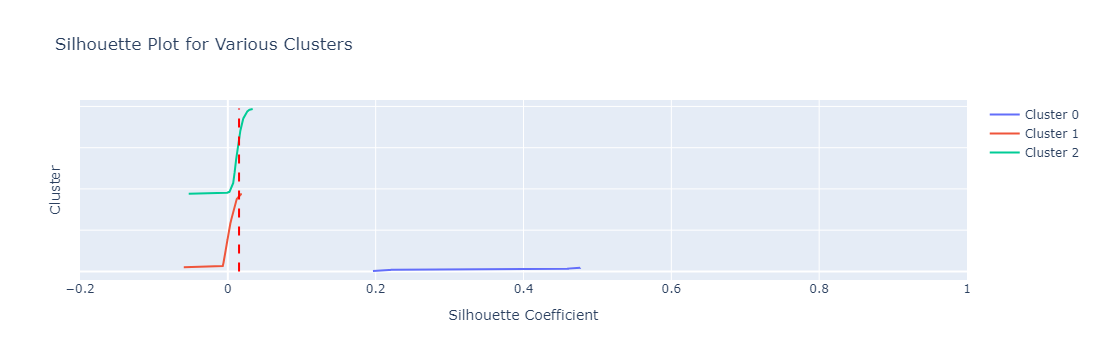

In [37]:
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def plot_silhouette_analysis(X, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    fig = go.Figure()

    for i in range(num_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        fig.add_trace(go.Scatter(
            y=np.arange(y_lower, y_upper),
            x=ith_cluster_silhouette_values,
            mode='lines',
            name=f'Cluster {i}',
            line=dict(color=px.colors.qualitative.Plotly[i])
        ))

        y_lower = y_upper + 10

    fig.add_shape(
        type="line",
        x0=silhouette_avg,
        y0=0,
        x1=silhouette_avg,
        y1=y_lower,
        line=dict(color="red", dash="dash"),
    )

    fig.update_layout(
        title="Silhouette Plot for Various Clusters",
        xaxis_title="Silhouette Coefficient",
        yaxis_title="Cluster",
        yaxis=dict(showticklabels=False),
        xaxis=dict(range=[-0.2, 1.0])  # Adjusted to show more negative values
    )

    fig.show()

plot_silhouette_analysis(X, num_clusters)
